(bayesian_vs_frequentist__v1)=
```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# Bayesian versus Frequentist Decision Rules

```{contents} Contents
:depth: 2
```

In addition to what's in Anaconda, this lecture will need the following libraries:

In [1]:
!pip install quantecon interpolation

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from numba import njit, prange, float64, int64
from numba.experimental import jitclass
from interpolation import interp
from math import gamma
from scipy.optimize import minimize

## Overview

This lecture follows up on ideas presented in the following lectures:

* {doc}`A Problem that Stumped Milton Friedman <wald_friedman>`
* {doc}`Exchangeability and Bayesian Updating <exchangeable>`
* {doc}`Likelihood Ratio Processes <likelihood_ratio_process>`

In {doc}`A Problem that Stumped Milton Friedman <wald_friedman>`  we described a problem
that a Navy Captain presented to Milton Friedman during World War II.

The Navy had instructed the Captain to use a decision rule for quality control that the Captain suspected
could be dominated by a better rule.

(The Navy had ordered the  Captain  to use  an instance of a **frequentist decision rule**.)

Milton Friedman recognized the Captain's conjecture as posing a challenging statistical problem that he and other
members of the US Government's Statistical Research Group at Columbia University proceeded to try to solve.

One of the members of the group, the great mathematician Abraham Wald, soon solved the problem.

A good way to formulate the problem is to use some ideas from Bayesian statistics that we describe in
this lecture {doc}`Exchangeability and Bayesian Updating <exchangeable>` and in this lecture
{doc}`Likelihood Ratio Processes <likelihood_ratio_process>`, which describes the link between Bayesian
updating and likelihood ratio processes.

The present lecture uses Python to generate simulations that evaluate expected losses under **frequentist** and **Bayesian**
decision rules for an instance of the Navy Captain's decision problem.

The simulations validate the Navy Captain's hunch that there is a better rule than the one the Navy had ordered him
to use.

## Setup

To formalize the problem of the Navy Captain whose questions posed the
problem that Milton Friedman and Allan Wallis handed over to Abraham
Wald, we consider a setting with the following parts.

- Each period a decision maker draws a non-negative random variable
  $Z$ from a probability distribution that he does not completely
  understand. He knows that two probability distributions are possible,
  $f_{0}$ and $f_{1}$, and that which ever distribution it
  is remains fixed over time. The decision maker believes that before
  the beginning of time, nature once and for all selected either
  $f_{0}$ or $f_1$ and that the probability that it
  selected $f_0$ is probability $\pi^{*}$.
- The decision maker observes a sample
  $\left\{ z_{i}\right\} _{i=0}^{t}$ from the the distribution
  chosen by nature.

The decision maker wants to decide which distribution actually governs
$Z$ and is worried by two types of errors and the losses that they
impose on him.

- a loss $\bar L_{1}$ from a **type I error** that occurs when he decides that
  $f=f_{1}$ when actually $f=f_{0}$
- a loss  $\bar L_{0}$ from a **type II error** that occurs when he decides that
  $f=f_{0}$ when actually $f=f_{1}$

The decision maker pays  a cost $c$ for drawing
another  $z$

We mainly borrow parameters from the quantecon lecture
{doc}`A Problem that Stumped Milton Friedman <wald_friedman>` except that we increase both $\bar L_{0}$
and $\bar L_{1}$ from $25$ to $100$ to encourage the
frequentist Navy Captain to take more draws before deciding.

We set the cost $c$ of taking one more draw  at $1.25$.

We set the probability distributions $f_{0}$ and $f_{1}$ to
be beta distributions with $a_{0}=b_{0}=1$, $a_{1}=3$, and
$b_{1}=1.2$, respectively.

Below is some Python code that sets up these objects.

In [3]:
@njit
def p(x, a, b):
    "Beta distribution."

    r = gamma(a + b) / (gamma(a) * gamma(b))

    return r * x**(a-1) * (1 - x)**(b-1)

We start with defining a `jitclass` that stores parameters and
functions we need to solve problems for both the Bayesian and
frequentist Navy Captains.

In [4]:
wf_data = [
    ('c', float64),           # unemployment compensation
    ('a0', float64),          # parameters of beta distribution
    ('b0', float64),
    ('a1', float64),
    ('b1', float64),
    ('L0', float64),          # cost of selecting f0 when f1 is true
    ('L1', float64),          # cost of selecting f1 when f0 is true
    ('π_grid', float64[:]),   # grid of beliefs π
    ('π_grid_size', int64),
    ('mc_size', int64),       # size of Monto Carlo simulation
    ('z0', float64[:]),       # sequence of random values
    ('z1', float64[:])        # sequence of random values
]

In [5]:
@jitclass(wf_data)
class WaldFriedman:

    def __init__(self,
                 c=1.25,
                 a0=1,
                 b0=1,
                 a1=3,
                 b1=1.2,
                 L0=100,
                 L1=100,
                 π_grid_size=200,
                 mc_size=1000):

        self.c, self.π_grid_size = c, π_grid_size
        self.a0, self.b0, self.a1, self.b1 = a0, b0, a1, b1
        self.L0, self.L1 = L0, L1
        self.π_grid = np.linspace(0, 1, π_grid_size)
        self.mc_size = mc_size

        self.z0 = np.random.beta(a0, b0, mc_size)
        self.z1 = np.random.beta(a1, b1, mc_size)

    def f0(self, x):

        return p(x, self.a0, self.b0)

    def f1(self, x):

        return p(x, self.a1, self.b1)

    def κ(self, z, π):
        """
        Updates π using Bayes' rule and the current observation z
        """

        a0, b0, a1, b1 = self.a0, self.b0, self.a1, self.b1

        π_f0, π_f1 = π * p(z, a0, b0), (1 - π) * p(z, a1, b1)
        π_new = π_f0 / (π_f0 + π_f1)

        return π_new

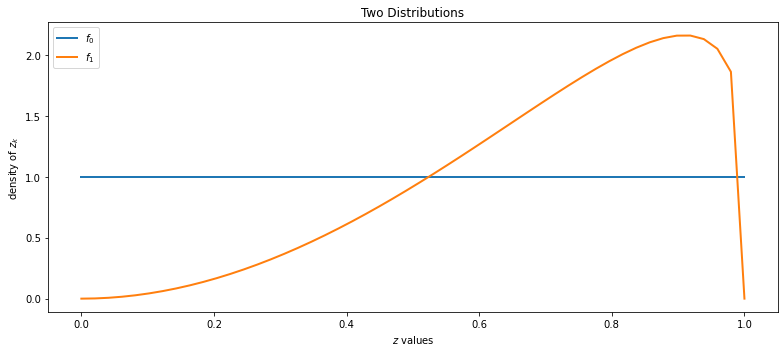

In [6]:
wf = WaldFriedman()

grid = np.linspace(0, 1, 50)

plt.figure()

plt.title("Two Distributions")
plt.plot(grid, wf.f0(grid), lw=2, label="$f_0$")
plt.plot(grid, wf.f1(grid), lw=2, label="$f_1$")

plt.legend()
plt.xlabel("$z$ values")
plt.ylabel("density of $z_k$")

plt.tight_layout()
plt.show()

Above, we plot the two possible probability densities $f_0$ and
$f_1$

## Frequentist Decision Rule

The Navy told the Captain to use a  frequentist decision rule.

In particular, it gave him a decision rule that the Navy had designed  by using
frequentist statistical theory to minimize an
expected loss function.

That decision rule is characterized by a sample size $t$ and a
cutoff $d$ associated with a likelihood ratio.

Let
$L\left(z^{t}\right)=\prod_{i=0}^{t}\frac{f_{0}\left(z_{i}\right)}{f_{1}\left(z_{i}\right)}$
be the likelihood ratio associated with observing the sequence
$\left\{ z_{i}\right\} _{i=0}^{t}$.

The decision rule associated with a sample size $t$ is:

- decide that $f_0$ is the distribution if the likelihood ratio
  is greater than $d$

To understand how that rule was engineered, let null and alternative
hypotheses be

- null: $H_{0}$: $f=f_{0}$,
- alternative $H_{1}$: $f=f_{1}$.

Given sample size $t$ and cutoff $d$, under the model
described above, the mathematical expectation of total loss is

```{math}
:label: val1

\begin{aligned}
\bar{V}_{fre}\left(t,d\right)=ct+\pi^{*}PFA\times \bar L_{1}+\left(1-\pi^{*}\right)\left(1-PD\right)\times \bar L_{0}
\end{aligned}
```

$$
\begin{aligned}
\textrm{where} \quad PFA & =\Pr\left\{ L\left(z^{t}\right)<d\mid q=f_{0}\right\} \\
PD & =\Pr\left\{ L\left(z^{t}\right)<d\mid q=f_{1}\right\}
\end{aligned}
$$

Here

- $PFA$ denotes the probability of a **false alarm**, i.e.,
  rejecting $H_0$ when it is true
- $PD$ denotes the probability of a **detection error**, i.e.,
  not rejecting $H_0$ when $H_1$ is true

For a given sample size $t$, the pairs $\left(PFA,PD\right)$
lie on a **receiver operating characteristic curve** and can be uniquely
pinned down by choosing $d$.

To see some receiver operating characteristic curves, please see this
lecture {doc}`Likelihood Ratio Processes <likelihood_ratio_process>`.

To solve for $\bar{V}_{fre}\left(t,d\right)$ numerically, we first
simulate sequences of $z$ when either $f_0$ or $f_1$
generates data.

In [7]:
N = 10000
T = 100

In [8]:
z0_arr = np.random.beta(wf.a0, wf.b0, (N, T))
z1_arr = np.random.beta(wf.a1, wf.b1, (N, T))

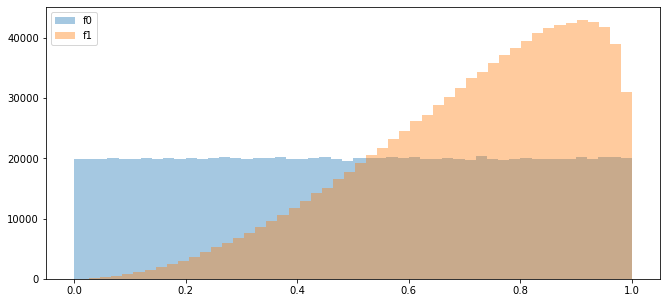

In [9]:
plt.hist(z0_arr.flatten(), bins=50, alpha=0.4, label='f0')
plt.hist(z1_arr.flatten(), bins=50, alpha=0.4, label='f1')
plt.legend()
plt.show()

We can compute sequences of likelihood ratios using simulated samples.

In [10]:
l = lambda z: wf.f0(z) / wf.f1(z)

In [11]:
l0_arr = l(z0_arr)
l1_arr = l(z1_arr)

L0_arr = np.cumprod(l0_arr, 1)
L1_arr = np.cumprod(l1_arr, 1)

With an empirical distribution of likelihood ratios in hand, we can draw
**receiver operating characteristic curves** by enumerating
$\left(PFA,PD\right)$ pairs given each sample size $t$.

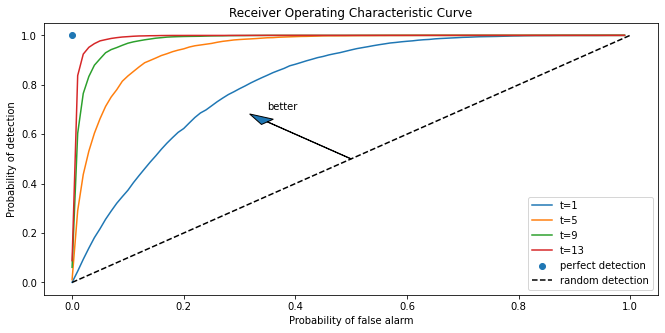

In [12]:
PFA = np.arange(0, 100, 1)

for t in range(1, 15, 4):
    percentile = np.percentile(L0_arr[:, t], PFA)
    PD = [np.sum(L1_arr[:, t] < p) / N for p in percentile]

    plt.plot(PFA / 100, PD, label=f"t={t}")

plt.scatter(0, 1, label="perfect detection")
plt.plot([0, 1], [0, 1], color='k', ls='--', label="random detection")

plt.arrow(0.5, 0.5, -0.15, 0.15, head_width=0.03)
plt.text(0.35, 0.7, "better")
plt.xlabel("Probability of false alarm")
plt.ylabel("Probability of detection")
plt.legend()
plt.title("Receiver Operating Characteristic Curve")
plt.show()

Our frequentist minimizes the expected total loss presented in equation
{eq}`val1` by choosing $\left(t,d\right)$.

Doing that delivers an expected loss

$$
\bar{V}_{fre}=\min_{t,d}\bar{V}_{fre}\left(t,d\right).
$$

We first consider the case in which
$\pi^{*}=\Pr\left\{ \text{nature selects }f_{0}\right\} =0.5$.

We can solve the minimization problem in two steps.

First, we fix $t$ and find the optimal cutoff $d$ and
consequently the minimal $\bar{V}_{fre}\left(t\right)$.

Here is Python code that does that and then plots a useful graph.

In [13]:
@njit
def V_fre_d_t(d, t, L0_arr, L1_arr, π_star, wf):

    N = L0_arr.shape[0]

    PFA = np.sum(L0_arr[:, t-1] < d) / N
    PD = np.sum(L1_arr[:, t-1] < d) / N

    V = π_star * PFA *wf. L1 + (1 - π_star) * (1 - PD) * wf.L0

    return V

In [14]:
def V_fre_t(t, L0_arr, L1_arr, π_star, wf):

    res = minimize(V_fre_d_t, 1, args=(t, L0_arr, L1_arr, π_star, wf), method='Nelder-Mead')
    V = res.fun
    d = res.x

    PFA = np.sum(L0_arr[:, t-1] < d) / N
    PD = np.sum(L1_arr[:, t-1] < d) / N

    return V, PFA, PD

In [15]:
def compute_V_fre(L0_arr, L1_arr, π_star, wf):

    T = L0_arr.shape[1]

    V_fre_arr = np.empty(T)
    PFA_arr = np.empty(T)
    PD_arr = np.empty(T)

    for t in range(1, T+1):
        V, PFA, PD = V_fre_t(t, L0_arr, L1_arr, π_star, wf)
        V_fre_arr[t-1] = wf.c * t + V
        PFA_arr[t-1] = PFA
        PD_arr[t-1] = PD

    return V_fre_arr, PFA_arr, PD_arr

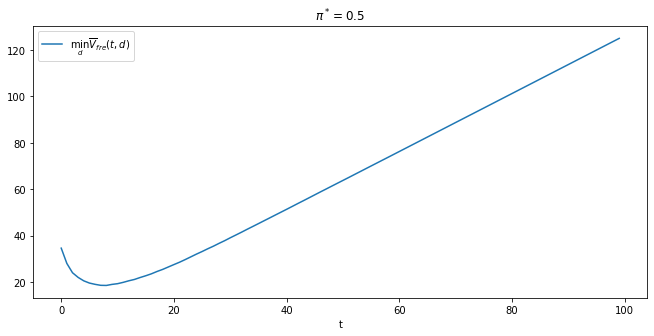

In [16]:
π_star = 0.5
V_fre_arr, PFA_arr, PD_arr = compute_V_fre(L0_arr, L1_arr, π_star, wf)

plt.plot(range(T), V_fre_arr, label='$\min_{d} \overline{V}_{fre}(t,d)$')
plt.xlabel('t')
plt.title('$\pi^*=0.5$')
plt.legend()
plt.show()

In [17]:
t_optimal = np.argmin(V_fre_arr) + 1

In [18]:
msg = f"The above graph indicates that minimizing over t tells the frequentist to draw {t_optimal} observations and then decide."
print(msg)

The above graph indicates that minimizing over t tells the frequentist to draw 9 observations and then decide.


Let’s now change the value of $\pi^{*}$ and watch how the decision
rule changes.

In [19]:
n_π = 20
π_star_arr = np.linspace(0.1, 0.9, n_π)

V_fre_bar_arr = np.empty(n_π)
t_optimal_arr = np.empty(n_π)
PFA_optimal_arr = np.empty(n_π)
PD_optimal_arr = np.empty(n_π)

for i, π_star in enumerate(π_star_arr):
    V_fre_arr, PFA_arr, PD_arr = compute_V_fre(L0_arr, L1_arr, π_star, wf)
    t_idx = np.argmin(V_fre_arr)

    V_fre_bar_arr[i] = V_fre_arr[t_idx]
    t_optimal_arr[i] = t_idx + 1
    PFA_optimal_arr[i] = PFA_arr[t_idx]
    PD_optimal_arr[i] = PD_arr[t_idx]

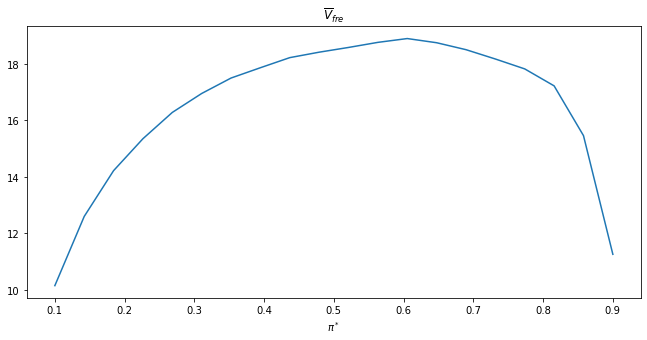

In [20]:
plt.plot(π_star_arr, V_fre_bar_arr)
plt.xlabel('$\pi^*$')
plt.title('$\overline{V}_{fre}$')

plt.show()

The following shows how optimal sample size $t$ and targeted
$\left(PFA,PD\right)$ change as $\pi^{*}$ varies.

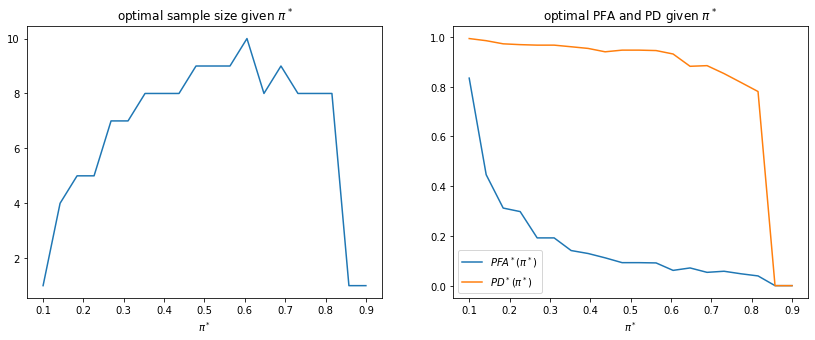

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(π_star_arr, t_optimal_arr)
axs[0].set_xlabel('$\pi^*$')
axs[0].set_title('optimal sample size given $\pi^*$')

axs[1].plot(π_star_arr, PFA_optimal_arr, label='$PFA^*(\pi^*)$')
axs[1].plot(π_star_arr, PD_optimal_arr, label='$PD^*(\pi^*)$')
axs[1].set_xlabel('$\pi^*$')
axs[1].legend()
axs[1].set_title('optimal PFA and PD given $\pi^*$')

plt.show()

## Bayesian Decision Rule

In  {doc}`A Problem that Stumped Milton Friedman <wald_friedman>`,
we learned how Abraham Wald confirmed the Navy
Captain’s hunch that there is a better decision rule.

We presented a Bayesian procedure that instructed the Captain to makes
decisions by comparing his current Bayesian posterior probability
$\pi$ with two cutoff probabilities called $\alpha$ and
$\beta$.

To proceed, we borrow some Python code from the quantecon
lecture {doc}`A Problem that Stumped Milton Friedman <wald_friedman>`
that computes $\alpha$ and $\beta$.

In [22]:
@njit(parallel=True)
def Q(h, wf):

    c, π_grid = wf.c, wf.π_grid
    L0, L1 = wf.L0, wf.L1
    z0, z1 = wf.z0, wf.z1
    mc_size = wf.mc_size

    κ = wf.κ

    h_new = np.empty_like(π_grid)
    h_func = lambda p: interp(π_grid, h, p)

    for i in prange(len(π_grid)):
        π = π_grid[i]

        # Find the expected value of J by integrating over z
        integral_f0, integral_f1 = 0, 0
        for m in range(mc_size):
            π_0 = κ(z0[m], π)  # Draw z from f0 and update π
            integral_f0 += min((1 - π_0) * L0, π_0 * L1, h_func(π_0))

            π_1 = κ(z1[m], π)  # Draw z from f1 and update π
            integral_f1 += min((1 - π_1) * L0, π_1 * L1, h_func(π_1))

        integral = (π * integral_f0 + (1 - π) * integral_f1) / mc_size

        h_new[i] = c + integral

    return h_new

In [23]:
@njit
def solve_model(wf, tol=1e-4, max_iter=1000):
    """
    Compute the continuation value function

    * wf is an instance of WaldFriedman
    """

    # Set up loop
    h = np.zeros(len(wf.π_grid))
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        h_new = Q(h, wf)
        error = np.max(np.abs(h - h_new))
        i += 1
        h = h_new

    if i == max_iter:
        print("Failed to converge!")

    return h_new

In [24]:
h_star = solve_model(wf)

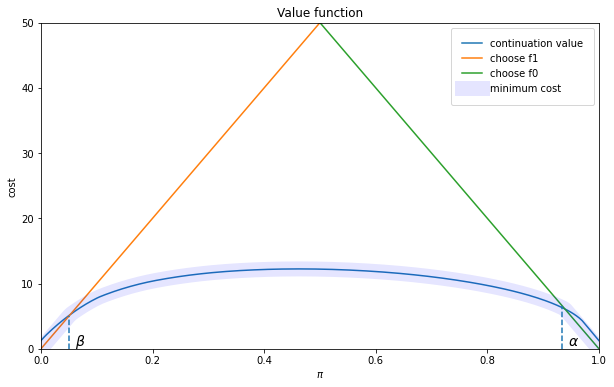

In [25]:
@njit
def find_cutoff_rule(wf, h):

    """
    This function takes a continuation value function and returns the
    corresponding cutoffs of where you transition between continuing and
    choosing a specific model
    """

    π_grid = wf.π_grid
    L0, L1 = wf.L0, wf.L1

    # Evaluate cost at all points on grid for choosing a model
    payoff_f0 = (1 - π_grid) * L0
    payoff_f1 = π_grid * L1

    # The cutoff points can be found by differencing these costs with
    # The Bellman equation (J is always less than or equal to p_c_i)
    β = π_grid[np.searchsorted(
                              payoff_f1 - np.minimum(h, payoff_f0),
                              1e-10)
               - 1]
    α = π_grid[np.searchsorted(
                              np.minimum(h, payoff_f1) - payoff_f0,
                              1e-10)
               - 1]

    return (β, α)

β, α = find_cutoff_rule(wf, h_star)
cost_L0 = (1 - wf.π_grid) * wf.L0
cost_L1 = wf.π_grid * wf.L1

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(wf.π_grid, h_star, label='continuation value')
ax.plot(wf.π_grid, cost_L1, label='choose f1')
ax.plot(wf.π_grid, cost_L0, label='choose f0')
ax.plot(wf.π_grid,
        np.amin(np.column_stack([h_star, cost_L0, cost_L1]),axis=1),
        lw=15, alpha=0.1, color='b', label='minimum cost')

ax.annotate(r"$\beta$", xy=(β + 0.01, 0.5), fontsize=14)
ax.annotate(r"$\alpha$", xy=(α + 0.01, 0.5), fontsize=14)

plt.vlines(β, 0, β * wf.L0, linestyle="--")
plt.vlines(α, 0, (1 - α) * wf.L1, linestyle="--")

ax.set(xlim=(0, 1), ylim=(0, 0.5 * max(wf.L0, wf.L1)), ylabel="cost",
       xlabel="$\pi$", title="Value function")

plt.legend(borderpad=1.1)
plt.show()

The above figure portrays the value function plotted against the decision
maker’s Bayesian posterior.

It also shows the probabilities $\alpha$ and $\beta$.

The Bayesian decision rule is:

- accept $H_0$ if $\pi \geq \alpha$
- accept $H_1$ if $\pi \leq \beta$
- delay deciding and draw another $z$ if
  $\beta \leq \pi \leq \alpha$

We can calculate two “objective” loss functions under this situation
conditioning on knowing for sure that nature has selected $f_{0}$,
in the first case, or $f_{1}$, in the second case.

1. under $f_{0}$,
   
   $$
   V^{0}\left(\pi\right)=\begin{cases}
   0 & \text{if }\alpha\leq\pi,\\
   c+EV^{0}\left(\pi^{\prime}\right) & \text{if }\beta\leq\pi<\alpha,\\
   \bar L_{1} & \text{if }\pi<\beta.
   \end{cases}
   $$
   
1. under $f_{1}$
   
   $$
   V^{1}\left(\pi\right)=\begin{cases}
   \bar L_{0} & \text{if }\alpha\leq\pi,\\
   c+EV^{1}\left(\pi^{\prime}\right) & \text{if }\beta\leq\pi<\alpha,\\
   0 & \text{if }\pi<\beta.
   \end{cases}
   $$
   

where
$\pi^{\prime}=\frac{\pi f_{0}\left(z^{\prime}\right)}{\pi f_{0}\left(z^{\prime}\right)+\left(1-\pi\right)f_{1}\left(z^{\prime}\right)}$.

Given a prior probability $\pi_{0}$, the expected loss for the
Bayesian is

$$
\bar{V}_{Bayes}\left(\pi_{0}\right)=\pi^{*}V^{0}\left(\pi_{0}\right)+\left(1-\pi^{*}\right)V^{1}\left(\pi_{0}\right).
$$

Below we write some Python code that computes
$V^{0}\left(\pi\right)$ and $V^{1}\left(\pi\right)$
numerically.

In [26]:
@njit(parallel=True)
def V_q(wf, flag):
    V = np.zeros(wf.π_grid_size)
    if flag == 0:
        z_arr = wf.z0
        V[wf.π_grid < β] = wf.L1
    else:
        z_arr = wf.z1
        V[wf.π_grid >= α] = wf.L0

    V_old = np.empty_like(V)

    while True:
        V_old[:] = V[:]
        V[(β <= wf.π_grid) & (wf.π_grid < α)] = 0

        for i in prange(len(wf.π_grid)):
            π = wf.π_grid[i]

            if π >= α or π < β:
                continue

            for j in prange(len(z_arr)):
                π_next = wf.κ(z_arr[j], π)
                V[i] += wf.c + interp(wf.π_grid, V_old, π_next)

            V[i] /= wf.mc_size

        if np.abs(V - V_old).max() < 1e-5:
            break

    return V

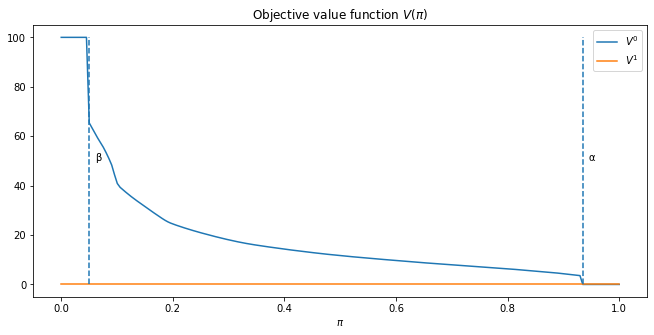

In [27]:
V0 = V_q(wf, 0)
V1 = V_q(wf, 1)

plt.plot(wf.π_grid, V0, label='$V^0$')
plt.plot(wf.π_grid, V1, label='$V^1$')
plt.vlines(β, 0, wf.L0, linestyle='--')
plt.text(β+0.01, wf.L0/2, 'β')
plt.vlines(α, 0, wf.L0, linestyle='--')
plt.text(α+0.01, wf.L0/2, 'α')
plt.xlabel('$\pi$')
plt.title('Objective value function $V(\pi)$')
plt.legend()
plt.show()

Given an assumed value for
$\pi^{*}=\Pr\left\{ \text{nature selects }f_{0}\right\}$, we can
then compute $\bar{V}_{Bayes}\left(\pi_{0}\right)$.

We can then determine an initial Bayesian prior $\pi_{0}^{*}$ that
minimizes this objective concept of expected loss.

The figure 9 below plots four cases corresponding to
$\pi^{*}=0.25,0.3,0.5,0.7$.

We observe that in each case $\pi_{0}^{*}$ equals $\pi^{*}$.

In [28]:
def compute_V_baye_bar(π_star, V0, V1, wf):

    V_baye = π_star * V0 + (1 - π_star) * V1
    π_idx = np.argmin(V_baye)
    π_optimal = wf.π_grid[π_idx]
    V_baye_bar = V_baye[π_idx]

    return V_baye, π_optimal, V_baye_bar

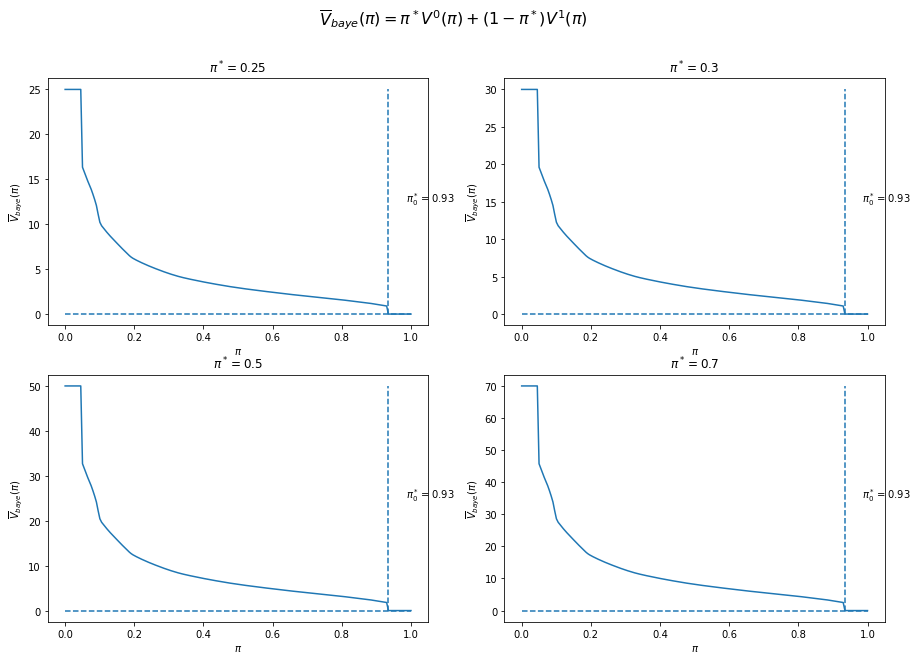

In [29]:
π_star_arr = [0.25, 0.3, 0.5, 0.7]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i, π_star in enumerate(π_star_arr):
    row_i = i // 2
    col_i = i % 2

    V_baye, π_optimal, V_baye_bar = compute_V_baye_bar(π_star, V0, V1, wf)

    axs[row_i, col_i].plot(wf.π_grid, V_baye)
    axs[row_i, col_i].hlines(V_baye_bar, 0, 1, linestyle='--')
    axs[row_i, col_i].vlines(π_optimal, V_baye_bar, V_baye.max(), linestyle='--')
    axs[row_i, col_i].text(π_optimal+0.05, (V_baye_bar + V_baye.max()) / 2,
                        '${\pi_0^*}=$'+f'{π_optimal:0.2f}')
    axs[row_i, col_i].set_xlabel('$\pi$')
    axs[row_i, col_i].set_ylabel('$\overline{V}_{baye}(\pi)$')
    axs[row_i, col_i].set_title('$\pi^*=$' + f'{π_star}')

fig.suptitle('$\overline{V}_{baye}(\pi)=\pi^*V^0(\pi) + (1-\pi^*)V^1(\pi)$', fontsize=16)
plt.show()

This pattern of outcomes holds more generally.

Thus, the following Python code generates the associated graph that
verifies the equality of $\pi_{0}^{*}$ to $\pi^{*}$ holds
for all $\pi^{*}$.

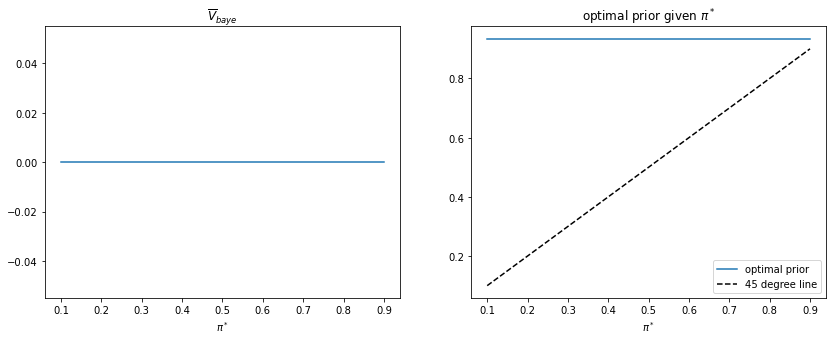

In [30]:
π_star_arr = np.linspace(0.1, 0.9, n_π)
V_baye_bar_arr = np.empty_like(π_star_arr)
π_optimal_arr = np.empty_like(π_star_arr)

for i, π_star in enumerate(π_star_arr):

    V_baye, π_optimal, V_baye_bar = compute_V_baye_bar(π_star, V0, V1, wf)

    V_baye_bar_arr[i] = V_baye_bar
    π_optimal_arr[i] = π_optimal

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(π_star_arr, V_baye_bar_arr)
axs[0].set_xlabel('$\pi^*$')
axs[0].set_title('$\overline{V}_{baye}$')

axs[1].plot(π_star_arr, π_optimal_arr, label='optimal prior')
axs[1].plot([π_star_arr.min(), π_star_arr.max()],
            [π_star_arr.min(), π_star_arr.max()],
            c='k', linestyle='--', label='45 degree line')
axs[1].set_xlabel('$\pi^*$')
axs[1].set_title('optimal prior given $\pi^*$')
axs[1].legend()

plt.show()

## Was the Navy Captain’s Hunch Correct?

We now compare average (i.e., frequentist) losses obtained by the
frequentist and Bayesian decision rules.

As a starting point, let’s compare average loss functions when
$\pi^{*}=0.5$.

In [31]:
π_star = 0.5

In [32]:
# frequentist
V_fre_arr, PFA_arr, PD_arr = compute_V_fre(L0_arr, L1_arr, π_star, wf)

# bayesian
V_baye = π_star * V0 + π_star * V1
V_baye_bar = V_baye.min()

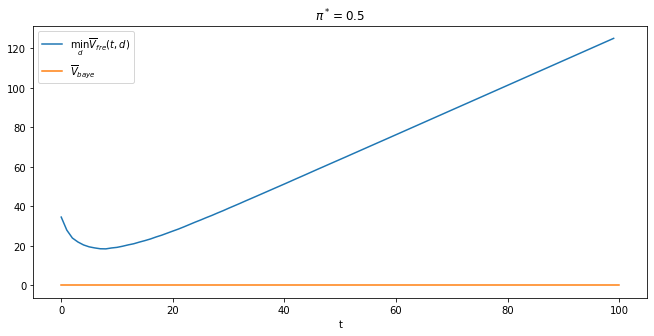

In [33]:
plt.plot(range(T), V_fre_arr, label='$\min_{d} \overline{V}_{fre}(t,d)$')
plt.plot([0, T], [V_baye_bar, V_baye_bar], label='$\overline{V}_{baye}$')
plt.xlabel('t')
plt.title('$\pi^*=0.5$')
plt.legend()
plt.show()

Evidently, there is no sample size $t$ at which the frequentist
decision rule attains a lower loss function than does the Bayesian rule.

Furthermore, the following graph indicates that the Bayesian decision
rule does better on average for all values of $\pi^{*}$.

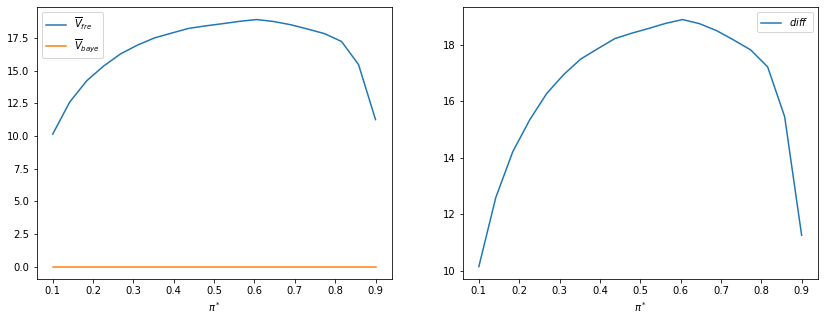

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(π_star_arr, V_fre_bar_arr, label='$\overline{V}_{fre}$')
axs[0].plot(π_star_arr, V_baye_bar_arr, label='$\overline{V}_{baye}$')
axs[0].legend()
axs[0].set_xlabel('$\pi^*$')

axs[1].plot(π_star_arr, V_fre_bar_arr - V_baye_bar_arr, label='$diff$')
axs[1].legend()
axs[1].set_xlabel('$\pi^*$')

plt.show()

The right panel of the above graph plots the difference
$\bar{V}_{fre}-\bar{V}_{Bayes}$.

It is always positive.

## More Details

We can provide more insights by focusing on the case in which
$\pi^{*}=0.5=\pi_{0}$.

In [35]:
π_star = 0.5

Recall that when $\pi^*=0.5$, the frequentist decision rule sets a
sample size `t_optimal` **ex ante**.

For our parameter settings, we can compute its value:

In [36]:
t_optimal

9

For convenience, let’s define `t_idx` as the Python array index
corresponding to `t_optimal` sample size.

In [37]:
t_idx = t_optimal - 1

## Distribution of Bayesian Decision Rule’s Time to Decide

By using simulations, we compute the frequency distribution of time to
deciding for the Bayesian decision rule and compare that time to the
frequentist rule’s fixed $t$.

The following Python code creates a graph that shows the frequency
distribution of Bayesian times to decide of Bayesian decision maker,
conditional on distribution $q=f_{0}$ or $q= f_{1}$
generating the data.

The blue and red dotted lines show averages for the Bayesian decision
rule, while the black dotted line shows the frequentist optimal sample
size $t$.

On average the Bayesian rule decides **earlier** than the frequentist
rule when $q= f_0$ and **later** when $q = f_1$.

In [38]:
@njit(parallel=True)
def check_results(L_arr, α, β, flag, π0):

    N, T = L_arr.shape

    time_arr = np.empty(N)
    correctness = np.empty(N)

    π_arr = π0 * L_arr / (π0 * L_arr + 1 - π0)

    for i in prange(N):
        for t in range(T):
            if (π_arr[i, t] < β) or (π_arr[i, t] > α):
                time_arr[i] = t + 1
                correctness[i] = (flag == 0 and π_arr[i, t] > α) or (flag == 1 and π_arr[i, t] < β)
                break

    return time_arr, correctness

In [39]:
time_arr0, correctness0 = check_results(L0_arr, α, β, 0, π_star)
time_arr1, correctness1 = check_results(L1_arr, α, β, 1, π_star)

# unconditional distribution
time_arr_u = np.concatenate((time_arr0, time_arr1))
correctness_u = np.concatenate((correctness0, correctness1))

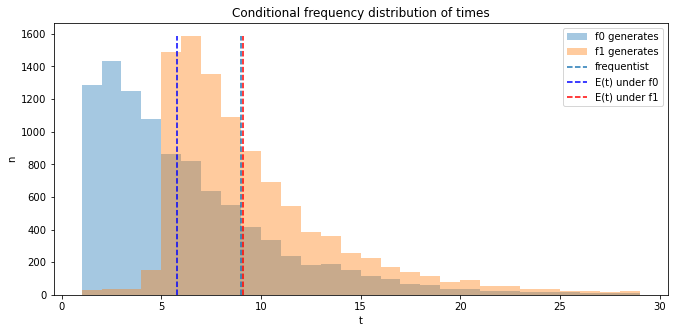

In [40]:
n1 = plt.hist(time_arr0, bins=range(1, 30), alpha=0.4, label='f0 generates')[0]
n2 = plt.hist(time_arr1, bins=range(1, 30), alpha=0.4, label='f1 generates')[0]
plt.vlines(t_optimal, 0, max(n1.max(), n2.max()), linestyle='--', label='frequentist')
plt.vlines(np.mean(time_arr0), 0, max(n1.max(), n2.max()),
           linestyle='--', color='b', label='E(t) under f0')
plt.vlines(np.mean(time_arr1), 0, max(n1.max(), n2.max()),
           linestyle='--', color='r', label='E(t) under f1')
plt.legend();

plt.xlabel('t')
plt.ylabel('n')
plt.title('Conditional frequency distribution of times')

plt.show()

Later we’ll figure out how these distributions ultimately affect
objective expected values under the two decision rules.

To begin, let’s look at simulations of the Bayesian’s beliefs over time.

We can easily compute the updated beliefs at any time $t$ using
the one-to-one mapping from $L_{t}$ to $\pi_{t}$ given
$\pi_0$ described in this lecture {doc}`Likelihood Ratio Processes <likelihood_ratio_process>`.

In [41]:
π0_arr = π_star * L0_arr / (π_star * L0_arr + 1 - π_star)
π1_arr = π_star * L1_arr / (π_star * L1_arr + 1 - π_star)

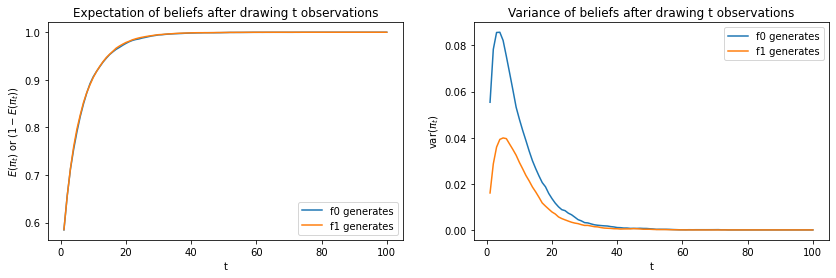

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

axs[0].plot(np.arange(1, π0_arr.shape[1]+1), np.mean(π0_arr, 0), label='f0 generates')
axs[0].plot(np.arange(1, π1_arr.shape[1]+1), 1 - np.mean(π1_arr, 0), label='f1 generates')
axs[0].set_xlabel('t')
axs[0].set_ylabel('$E(\pi_t)$ or ($1 - E(\pi_t)$)')
axs[0].set_title('Expectation of beliefs after drawing t observations')
axs[0].legend()

axs[1].plot(np.arange(1, π0_arr.shape[1]+1), np.var(π0_arr, 0), label='f0 generates')
axs[1].plot(np.arange(1, π1_arr.shape[1]+1), np.var(π1_arr, 0), label='f1 generates')
axs[1].set_xlabel('t')
axs[1].set_ylabel('var($\pi_t$)')
axs[1].set_title('Variance of beliefs after drawing t observations')
axs[1].legend()

plt.show()

The above figures compare averages and variances of updated Bayesian
posteriors after $t$ draws.

The left graph compares $E\left(\pi_{t}\right)$ under
$f_{0}$ to $1-E\left(\pi_{t}\right)$ under $f_{1}$:
they lie on top of each other.

However, as the right hand size graph shows, there is significant
difference in variances when $t$ is small: the variance is lower
under $f_{1}$.

The difference in variances is the reason that the Bayesian decision
maker waits longer to decide when $f_{1}$ generates the data.

The code below plots outcomes of constructing an unconditional
distribution by simply pooling the simulated data across the two
possible distributions $f_0$ and $f_1$.

The pooled distribution describes a sense in which on average the
Bayesian decides earlier, an outcome that seems at least partly to
confirm the Navy Captain’s hunch.

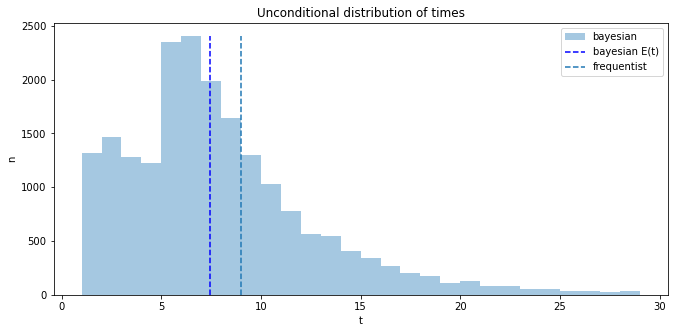

In [43]:
n = plt.hist(time_arr_u, bins=range(1, 30), alpha=0.4, label='bayesian')[0]
plt.vlines(np.mean(time_arr_u), 0, n.max(), linestyle='--',
           color='b', label='bayesian E(t)')
plt.vlines(t_optimal, 0, n.max(), linestyle='--', label='frequentist')
plt.legend()

plt.xlabel('t')
plt.ylabel('n')
plt.title('Unconditional distribution of times')

plt.show()

## Probability of Making Correct Decision

Now we use simulations to compute the fraction of samples in which the
Bayesian and the frequentist decision rules decide correctly.

For the frequentist rule, the probability of making the correct decision
under $f_{1}$ is the optimal probability of detection given
$t$ that we defined earlier, and similarly it equals $1$
minus the optimal probability of a false alarm under $f_{0}$.

Below we plot these two probabilities for the frequentist rule, along
with the conditional probabilities that the Bayesian rule decides before
$t$ *and* that the decision is correct.

In [44]:
# optimal PFA and PD of frequentist with optimal sample size
V, PFA, PD = V_fre_t(t_optimal, L0_arr, L1_arr, π_star, wf)

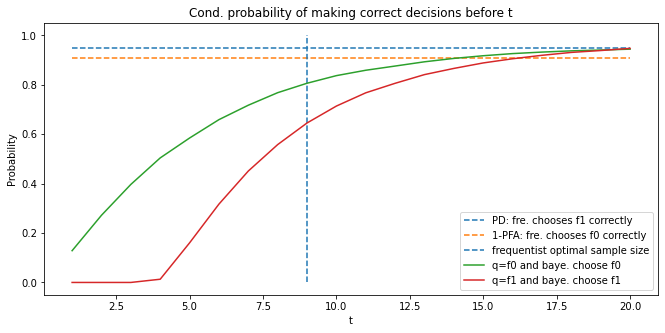

In [45]:
plt.plot([1, 20], [PD, PD], linestyle='--', label='PD: fre. chooses f1 correctly')
plt.plot([1, 20], [1-PFA, 1-PFA], linestyle='--', label='1-PFA: fre. chooses f0 correctly')
plt.vlines(t_optimal, 0, 1, linestyle='--', label='frequentist optimal sample size')

N = time_arr0.size
T_arr = np.arange(1, 21)
plt.plot(T_arr, [np.sum(correctness0[time_arr0 <= t] == 1) / N for t in T_arr],
        label='q=f0 and baye. choose f0')
plt.plot(T_arr, [np.sum(correctness1[time_arr1 <= t] == 1) / N for t in T_arr],
        label='q=f1 and baye. choose f1')
plt.legend(loc=4)

plt.xlabel('t')
plt.ylabel('Probability')
plt.title('Cond. probability of making correct decisions before t')

plt.show()

By averaging using $\pi^{*}$, we also plot the unconditional
distribution.

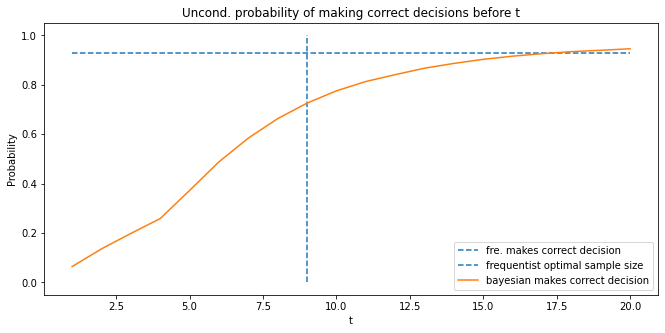

In [46]:
plt.plot([1, 20], [(PD + 1 - PFA) / 2, (PD + 1 - PFA) / 2],
        linestyle='--', label='fre. makes correct decision')
plt.vlines(t_optimal, 0, 1, linestyle='--', label='frequentist optimal sample size')

N = time_arr_u.size
plt.plot(T_arr, [np.sum(correctness_u[time_arr_u <= t] == 1) / N for t in T_arr],
        label="bayesian makes correct decision")
plt.legend()

plt.xlabel('t')
plt.ylabel('Probability')
plt.title('Uncond. probability of making correct decisions before t')

plt.show()

## Distribution of Likelihood Ratios at Frequentist’s $t$

Next we use simulations to construct distributions of likelihood ratios
after $t$ draws.

To serve as useful reference points, we also show likelihood ratios that
correspond to the Bayesian cutoffs $\alpha$ and $\beta$.

In order to exhibit the distribution more clearly, we report logarithms
of likelihood ratios.

The graphs below reports two distributions, one conditional on
$f_0$ generating the data, the other conditional on $f_1$
generating the data.

In [47]:
Lα = (1 - π_star) *  α / (π_star - π_star * α)
Lβ = (1 - π_star) *  β / (π_star - π_star * β)

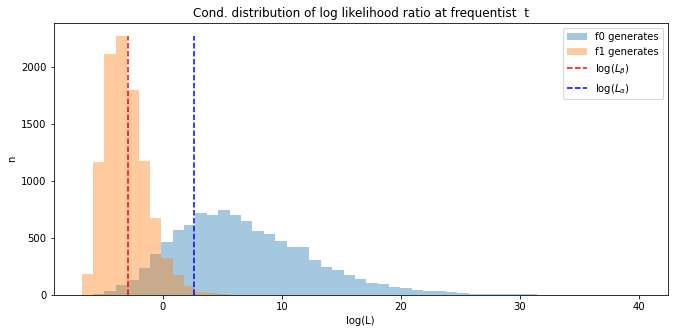

In [48]:
L_min = min(L0_arr[:, t_idx].min(), L1_arr[:, t_idx].min())
L_max = max(L0_arr[:, t_idx].max(), L1_arr[:, t_idx].max())
bin_range = np.linspace(np.log(L_min), np.log(L_max), 50)
n0 = plt.hist(np.log(L0_arr[:, t_idx]), bins=bin_range, alpha=0.4, label='f0 generates')[0]
n1 = plt.hist(np.log(L1_arr[:, t_idx]), bins=bin_range, alpha=0.4, label='f1 generates')[0]

plt.vlines(np.log(Lβ), 0, max(n0.max(), n1.max()), linestyle='--', color='r', label='log($L_β$)')
plt.vlines(np.log(Lα), 0, max(n0.max(), n1.max()), linestyle='--', color='b', label='log($L_α$)')
plt.legend()

plt.xlabel('log(L)')
plt.ylabel('n')
plt.title('Cond. distribution of log likelihood ratio at frequentist  t')

plt.show()

The next graph plots the unconditional distribution of Bayesian times to
decide, constructed as earlier by pooling the two conditional
distributions.

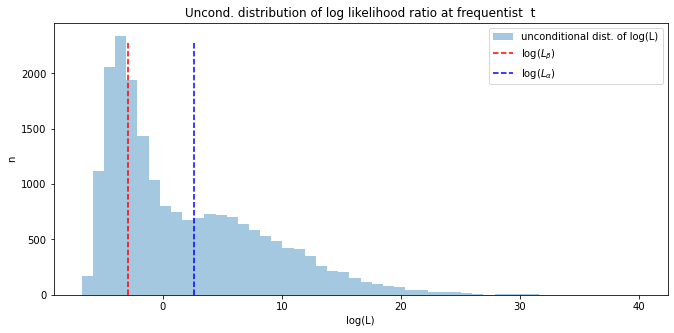

In [49]:
plt.hist(np.log(np.concatenate([L0_arr[:, t_idx], L1_arr[:, t_idx]])),
        bins=50, alpha=0.4, label='unconditional dist. of log(L)')
plt.vlines(np.log(Lβ), 0, max(n0.max(), n1.max()), linestyle='--', color='r', label='log($L_β$)')
plt.vlines(np.log(Lα), 0, max(n0.max(), n1.max()), linestyle='--', color='b', label='log($L_α$)')
plt.legend()

plt.xlabel('log(L)')
plt.ylabel('n')
plt.title('Uncond. distribution of log likelihood ratio at frequentist  t')

plt.show()